In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
%pwd

'/Users/chris/Documents_local/school/computer_vision_116/Homographies'

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/116/homography/Homographies

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/116/homography/Homographies'
/Users/chris/Documents_local/school/computer_vision_116/Homographies


In [5]:
left_img = plt.imread('left.JPG')
center_img = plt.imread('center.JPG')
right_img = plt.imread('right.JPG')
left_img = np.rot90(left_img, 3)
center_img = np.rot90(center_img, 3)
right_img = np.rot90(right_img, 3)

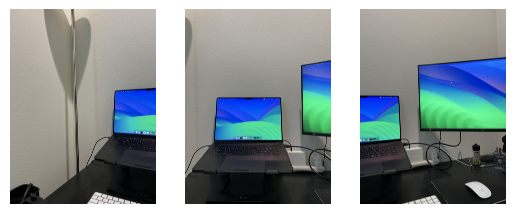

In [6]:
plt.subplot(1,3,1)
plt.imshow(left_img)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(center_img)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(right_img)
plt.axis('off')

plt.show()

In [7]:
li = []
with open("location.txt", "r") as f:
    for line in f:
        li.append(line.rstrip())
li

['[(2185, 1713), (2141, 2612), (1753, 3088), (2824, 1710), (2407, 2908)]',
 '[(678, 1857), (604, 2776), (152, 3337), (1264, 1886), (870, 3051)]',
 '[(1984, 1857), (2028, 2772), (2239, 3340), (1396, 1883), (1649, 3052)]',
 '[(802, 1824), (860, 2748), (1066, 3264), (144, 1851), (454, 3074)]']

In [8]:
import ast
for i in range(len(li)):
    li[i] = ast.literal_eval(li[i])
li

[[(2185, 1713), (2141, 2612), (1753, 3088), (2824, 1710), (2407, 2908)],
 [(678, 1857), (604, 2776), (152, 3337), (1264, 1886), (870, 3051)],
 [(1984, 1857), (2028, 2772), (2239, 3340), (1396, 1883), (1649, 3052)],
 [(802, 1824), (860, 2748), (1066, 3264), (144, 1851), (454, 3074)]]

In [9]:
H1_left_points = li[0]
H1_center_points = li[1]
H2_center_points = li[2]
H2_right_points = li[3]
print(H1_left_points, H1_center_points, H2_center_points, H2_right_points)

[(2185, 1713), (2141, 2612), (1753, 3088), (2824, 1710), (2407, 2908)] [(678, 1857), (604, 2776), (152, 3337), (1264, 1886), (870, 3051)] [(1984, 1857), (2028, 2772), (2239, 3340), (1396, 1883), (1649, 3052)] [(802, 1824), (860, 2748), (1066, 3264), (144, 1851), (454, 3074)]


In [10]:
def compute_homography(src_pts, dst_pts):
    """
    Compute the homography matrix from point correspondences using least squares.
    src_pts and dst_pts are lists of tuples [(x, y), (x, y), ...] from the source
    and destination images respectively.
    """
    A = []
    for (x1, y1), (x2, y2) in zip(src_pts, dst_pts):
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2])
    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))
    return H / H[2, 2]  # Normalize the homography matrix

In [11]:
H1 = compute_homography(H1_left_points, H1_center_points)
H2 = compute_homography(H2_right_points, H2_center_points)
print(f"H1: {H1}")
print(f"H2: {H2}")

H1: [[ 1.52432789e+00 -5.91201139e-02 -2.29829643e+03]
 [ 4.46238597e-01  1.30513151e+00 -6.51852222e+02]
 [ 1.99069757e-04 -3.33445660e-05  1.00000000e+00]]
H2: [[ 6.44676847e-01 -4.29299714e-02  1.31555571e+03]
 [-1.88708255e-01  8.21892040e-01  2.95966271e+02]
 [-1.00097118e-04 -1.87994834e-05  1.00000000e+00]]


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def warp_image(image, H):
  height, width = image.shape[:2]
  transformed_image = cv2.warpPerspective(image, H, (width, height))
  # transformed_image = cv2.resize(transformed_image, (width, height))
  return transformed_image


In [13]:
def calculate_size(images, homographies):
    """
    Calculate the size of the output panorama canvas accurately, ensuring no part of the images is cut off.
    """
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')

    for img, H in zip(images, homographies):
        h, w = img.shape[:2]
        corners = np.array([[0, 0], [0, h], [w, h], [w, 0]], dtype=np.float32).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners, H)

        # Update min and max x, y based on warped corners
        min_x = min(min_x, warped_corners[:, :, 0].min())
        max_x = max(max_x, warped_corners[:, :, 0].max())
        min_y = min(min_y, warped_corners[:, :, 1].min())
        max_y = max(max_y, warped_corners[:, :, 1].max())

    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))

    # The offset for translating images to ensure all are visible
    offset_x = -min_x
    offset_y = -min_y

    return (width, height), (offset_x, offset_y)

def warp_images(images, homographies, output_size, offsets):
    """
    Warp images onto the panorama canvas with correct offsets, ensuring all images are fully visible.
    """
    canvas_width, canvas_height = output_size
    panorama = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    for img, H in zip(images, homographies):
        # Adjust the homography to include the offset
        offset_x, offset_y = offsets
        H_offset = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]]) @ H
        warped_image = cv2.warpPerspective(img, H_offset, (canvas_width, canvas_height))

        # Blend the warped image onto the panorama
        mask = (warped_image > 0)
        panorama[mask] = warped_image[mask]

    return panorama

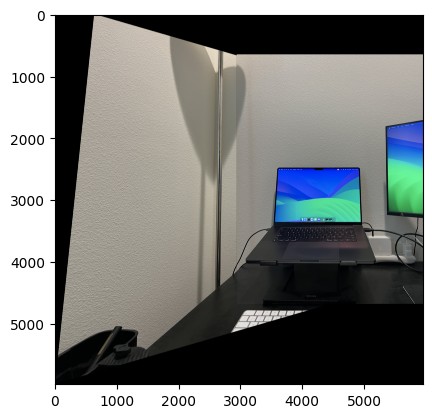

In [16]:
images = [left_img, center_img]
H_identical = np.eye(3)
homography = [H1, H_identical]
output_size, base_offset = calculate_size(images, homography)
left_warp_img = warp_images(images, homography, output_size, base_offset)
plt.imshow(left_warp_img)
plt.show()

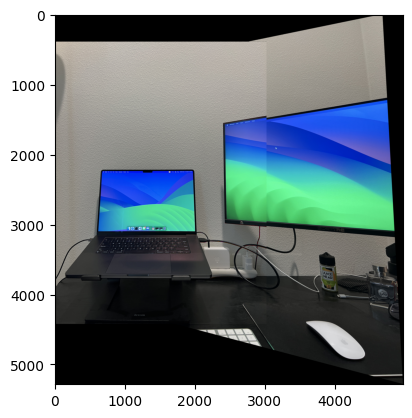

In [17]:
images = [right_img, center_img]
H_identical = np.eye(3)
homography = [H2, H_identical]
output_size, base_offset = calculate_size(images, homography)
left_warp_img = warp_images(images, homography, output_size, base_offset)
plt.imshow(left_warp_img)
plt.show()

In [115]:
def calculate_size(images, homographies):
    """
    Calculate the size of the output panorama canvas accurately, ensuring no part of the images is cut off.
    """
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')

    for img, H in zip(images, homographies):
        h, w = img.shape[:2]
        corners = np.array([[0, 0], [0, h], [w, h], [w, 0]], dtype=np.float32).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners, H)

        # Update min and max x, y based on warped corners
        min_x = min(min_x, warped_corners[:, :, 0].min())
        max_x = max(max_x, warped_corners[:, :, 0].max())
        min_y = min(min_y, warped_corners[:, :, 1].min())
        max_y = max(max_y, warped_corners[:, :, 1].max())

    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))

    # The offset for translating images to ensure all are visible
    offset_x = -min_x
    offset_y = -min_y

    return (width, height), (offset_x, offset_y)



def warp_images(images, homographies, output_size, offsets):
    """
    Warp images onto the panorama canvas with correct offsets, ensuring all images are fully visible.
    """
    canvas_width, canvas_height = output_size
    panorama = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    for img, H in zip(images, homographies):
        # Adjust the homography to include the offset
        offset_x, offset_y = offsets
        H_offset = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]]) @ H
        warped_image = cv2.warpPerspective(img, H_offset, (canvas_width, canvas_height))

        # Blend the warped image onto the panorama
        mask = (warped_image > 0)
        panorama[mask] = warped_image[mask]

    return panorama



def create_panorama(center_image, left_image, right_image, H1, H2):
    """
    Create a panorama by warping the left and right images using the homographies H1 and H2,
    then combining them with the center image. Assumes H1 maps left to center, and H2 maps right to center.
    """
    # Placeholder for identity matrix for the center image
    H_identity = np.eye(3)

    images = [left_image, center_image, right_image]
    homographies = [H1, H_identity, H2]

    # Calculate the output size and base offset
    output_size, base_offset = calculate_size(images, homographies)

    # Warp images onto the panorama canvas
    panorama = warp_images(images, homographies, output_size, base_offset)

    return panorama


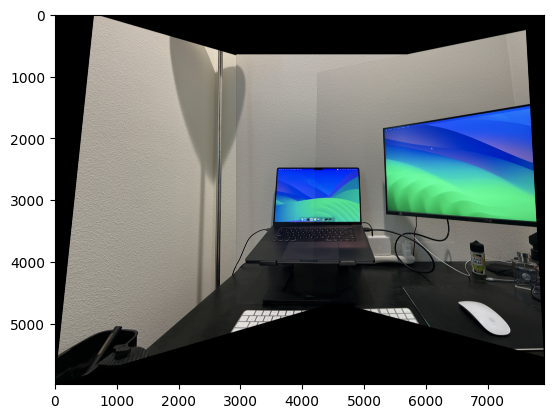

In [116]:
result = create_panorama(center_img, left_img, right_img, H1, H2)
plt.imshow(result)
plt.show()

### I collaborate Lucas belvedere